## **DATA 620 Final Project**

In this project, the objective is to use graph analysis to identify similarities in California ballot propositions, based on the text that is included in the explainer text. 

For this analysis, the bipartite network graph is comprised of the following nodes:
1. Prop Name - this is a unique identification code that identifies the proposition name along with the year the proposition was on the ballot
2. Word Token - this represents the unique word toekn that is included in the explainer text

The edges of the graph are weighted edges. If a word appears in the explainer text for a proposition then there will be an adge between the word and the proposition name. The weight of the edge is based on the number of times the word appears in the document corpus for the specific ballot initiative. 

The idea is that if there is a common theme between a state proposition (e.g. environmental issue, education, etc.) that there would be several word tokens that are similar between them


#### **1. Project Setup**

In [28]:
import pandas as pd

In [29]:
import pandas as pd
import re
import datetime as dt
import os
import math

In [30]:
import requests

In [31]:
from bs4 import BeautifulSoup

In [32]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer

In [121]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [122]:
import numpy as np

In [33]:
import networkx as net
from networkx.algorithms import bipartite
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean
import os.path
from plotnine import *

In [34]:
nltk.download('stopwords')   
nltk.download('wordnet')

wordnet_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/korymartin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/korymartin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### **2. Create Text Corpus**

Ballot initiative text

This is focused on importing the data for the corpus representing the different ballot initiatives. 

Web Scraper for Data

Main sources:
1. [Secretary of State](https://vigarchive.sos.ca.gov/)
2. [Legislative Analysts' Office](https://lao.ca.gov/BallotAnalysis)
3. [UC San Francisco Law School](https://repository.uclawsf.edu/ca_ballot_props/)
4. [Wikipedia](https://en.wikipedia.org/wiki/List_of_California_ballot_propositions)
5. [League of Women Voters](https://cavotes.org/ballot-measures/)

The final dataframe should have the following structure:
- Source Name
- Source Link
- Election Year / Date
- Identifier (STATE MEASURE PROP_NUMBER)
- Measure Name
- Abstract / Summary Text

2.2.1 Voter Guide Archive

In [35]:
main_url = 'https://vigarchive.sos.ca.gov/'
data = requests.get(main_url)

html = BeautifulSoup(data.text,'html.parser')
main_content = html.find(id="mainCont")
li_tags = main_content.find('ul').find_all('li')

prop_info = []

for i in li_tags:
    href = i.find('a')['href']
    election_title = i.text
    new_url=main_url+href
    
    mini_dict={'new_url':new_url, 'election_title':election_title}
    prop_info.append(mini_dict)


In [36]:
prop_info

[{'new_url': 'https://vigarchive.sos.ca.gov/2024/primary/',
  'election_title': '2024 California Primary Election'},
 {'new_url': 'https://vigarchive.sos.ca.gov/2022/general/',
  'election_title': '2022 California General Election'},
 {'new_url': 'https://vigarchive.sos.ca.gov/2022/',
  'election_title': '2022 California Primary Election'},
 {'new_url': 'https://vigarchive.sos.ca.gov/2021/',
  'election_title': '2021 California Recall Election'},
 {'new_url': 'https://vigarchive.sos.ca.gov/2020/primary/',
  'election_title': '2020 California Primary Election'},
 {'new_url': 'https://vigarchive.sos.ca.gov/2018/primary/',
  'election_title': '2018 California Primary Election'},
 {'new_url': 'https://vigarchive.sos.ca.gov/2018/general/',
  'election_title': '2018 California General Election'},
 {'new_url': 'https://vigarchive.sos.ca.gov/2016/general/',
  'election_title': '2016 California General Election'},
 {'new_url': 'https://vigarchive.sos.ca.gov/2016/primary/',
  'election_title': '

In [37]:

prop_links = []

for prop in prop_info:

    url = prop['new_url']
    data = requests.get(url)
    new_html = BeautifulSoup(data.text,'html.parser')
    if new_html.find(id='mainNavCtnr'):
        main_nav = new_html.find_all(id="mainNavCtnr")
    else:
        main_nav = new_html.find_all(id="globalLinks")
    
    if main_nav:
        li_tags = main_nav[0].find_all('li')
        
        
        
        for li in li_tags:
            
            if li.text =='Propositions':
                href = li.find('a')['href']
                #prop_links.append(href)
                prop['prop_group_url'] = main_url[:-1]+href
                prop_links.append(prop)
                

In [38]:
prop_links

[{'new_url': 'https://vigarchive.sos.ca.gov/2024/primary/',
  'election_title': '2024 California Primary Election',
  'prop_group_url': 'https://vigarchive.sos.ca.gov/2024/primary/propositions/'},
 {'new_url': 'https://vigarchive.sos.ca.gov/2022/general/',
  'election_title': '2022 California General Election',
  'prop_group_url': 'https://vigarchive.sos.ca.gov/2022/general/propositions/'},
 {'new_url': 'https://vigarchive.sos.ca.gov/2020/primary/',
  'election_title': '2020 California Primary Election',
  'prop_group_url': 'https://vigarchive.sos.ca.gov/2020/primary/propositions/'},
 {'new_url': 'https://vigarchive.sos.ca.gov/2018/primary/',
  'election_title': '2018 California Primary Election',
  'prop_group_url': 'https://vigarchive.sos.ca.gov/2018/primary/propositions/'},
 {'new_url': 'https://vigarchive.sos.ca.gov/2018/general/',
  'election_title': '2018 California General Election',
  'prop_group_url': 'https://vigarchive.sos.ca.gov/2018/general/propositions/'},
 {'new_url': 'h

In [39]:

new_prop_info = []

for item in prop_links:

    data = requests.get(item['prop_group_url'])
    html = BeautifulSoup(data.text,'html.parser')
    li_content = html.find('ol').find_all('li')[2].contents
    for i in li_content:
        result = re.findall('[\w]+.\d{1,2},.\d{4}',i.text)
        if len(result) > 0:
            election_date = result[0]
    if len(html.find_all(id='mainCont')) > 0:
        main_content = html.find_all(id='mainCont')[0]
    else:
        main_content = html.find_all(id='content')[0]
    prop_sub_links = main_content.find_all('ul')[0].find_all('li')


    for prop_item in prop_sub_links:
        new_url = main_url[:-1]+prop_item.find('a')['href']

        if len(re.findall('.gov\/[\d]{4}\/[\w]+', new_url)) > 0:
            mini_dict = {}
            title = prop_item.text

            mini_dict['prop_name'] = title
            mini_dict['election_date'] = election_date
            mini_dict['prop_url'] = new_url
            new_prop_info.append(mini_dict)

In [40]:

prop_details = []

for item in new_prop_info:


    data =requests.get(item['prop_url'])
    html = BeautifulSoup(data.text,'html.parser')
    if html.find_all('aside')[0].find(id='propSubpages'):
        href = html.find_all('aside')[0].find(id='propSubpages').find_all('li')[0].find('a')['href']
        new_url = main_url[:-1]+href
        data = requests.get(new_url)
        html = BeautifulSoup(data.text,'html.parser')
        if re.findall('.gov\/2012',item['prop_url']):
            top = html.find_all(id='content')
            prop_title = top[0].find_all('div')[2].find(class_='propName').text
            summary_text = top[0].find_all('ul')[1].find_all('li')

            for summary in summary_text:
                    mini_dict = {}
                    mini_dict['prop_title'] = prop_title
                    mini_dict['prop_name'] = item['prop_name']
                    mini_dict['election_date'] = item['election_date']
                    mini_dict['prop_summary'] = summary.text
                    prop_details.append(mini_dict)
        else:
            top = html.find_all(id='top')
            if len(top) > 0:
                prop_title = top[0].find_all(id='mainCont')[0].find_all('div')[2].find(class_='propName').text
                summary_text = top[0].find_all(id='mainCont')[0].find_all('ul')[1].find_all('li')

                for summary in summary_text:
                    mini_dict = {}
                    mini_dict['prop_title'] = prop_title
                    mini_dict['prop_name'] = item['prop_name']
                    mini_dict['election_date'] = item['election_date']
                    mini_dict['prop_summary'] = summary.text
                    prop_details.append(item)

    

In [41]:
df1 = pd.DataFrame(prop_details)

In [42]:
df1.head()
df1['source_url'] = main_url
df1['source'] = 'California Secretary of State'

2.2.2. Legislative Analyst's Office

In [43]:
prop_summary_df = []

main_url = 'https://lao.ca.gov/BallotAnalysis/Propositions?date=12%2F31%2F9999&propNumber=&searchTerm='
data = requests.get(main_url)
html = BeautifulSoup(data.text, 'html.parser')
container = html.find(class_='container')
prop_info = container.find(class_='row').find_all(class_='col-md-8')[0].find_all(class_='card')

for prop in prop_info:
    
    prop_name = prop.find(class_="card-title").text
    election_date = prop.find("small").text
    prop_desc = prop.find(class_="card-subtitle").text
    prop_summary = prop.find(class_="card-text").find_all('p')

    for i in range(1):
        mini_dict = {}
        mini_dict['election_date'] = election_date
        mini_dict['prop_name'] = prop_name
        mini_dict['prop_desc'] = prop_desc
        if len(prop_summary) > i:
            mini_dict['prop_summary'] = prop_summary[i].text
        else:
            mini_dict['prop_summary'] = ""
        prop_summary_df.append(mini_dict)
    

In [44]:
df2 = pd.DataFrame(prop_summary_df)

In [45]:
df2['source_url'] = 'https://lao.ca.gov/BallotAnalysis/'
df2['source'] = 'Legislative Analysts Office'

In [46]:
df2.head()

,election_date,prop_name,prop_desc,prop_summary,source_url,source
0,"March 5, 2024",Proposition 1,Authorizes $6.38 Billion in Bonds to Build Men...,A YES vote on this measure means: Counties wou...,https://lao.ca.gov/BallotAnalysis/,Legislative Analysts Office
1,"November 8, 2022",Proposition 1,Constitutional Right to Reproductive Freedom. ...,A YES vote on this measure means: The Californ...,https://lao.ca.gov/BallotAnalysis/,Legislative Analysts Office
2,"November 8, 2022",Proposition 26,"Allows In-Person Roulette, Dice Games, Sports ...",A YES vote on this measure means: Four racetra...,https://lao.ca.gov/BallotAnalysis/,Legislative Analysts Office
3,"November 8, 2022",Proposition 27,Allows Online and Mobile Sports Wagering Outsi...,A YES vote on this measure means: Licensed tri...,https://lao.ca.gov/BallotAnalysis/,Legislative Analysts Office
4,"November 8, 2022",Proposition 28,Provides Additional Funding for Arts and Music...,A YES vote on this measure means: The state wo...,https://lao.ca.gov/BallotAnalysis/,Legislative Analysts Office


2.2.3. League of Women Voters

In [47]:
base_url = 'https://cavotes.org'
main_url = 'https://cavotes.org/ballot-measures/'
data = requests.get(main_url)
html = BeautifulSoup(data.text, 'html.parser')
li_tags = html.find_all('li')
slugs = []

for li in li_tags:
    a_tag = li.find('a',attrs={'href':True})
    if a_tag:
    
        href= a_tag['href']
        match_result = re.search('ballot-measure\/[\d]{4}',href)
        if match_result:
            #print(href)
            slugs.append(href)
prop_info = []

for slug in slugs:

    new_url = base_url+slug
    data = requests.get(new_url)
    html = BeautifulSoup(data.text,'html.parser')
    prop_num = html.find_all(class_='wp-block-details')[0].find_all('p')[0].contents[1].strip()
    prop_name =html.find_all(class_='wp-block-details')[0].find_all('p')[0].contents[4]
    #prop_election = html.find_all(class_='wp-block-details')[0].find_all('p')[0].contents[10].strip()
    html_content = html.find_all(class_='wp-block-details')[0].find_all('p')[0].contents
    #print(html_content)
    for i in html_content:    
        if len(re.findall('\d{4}.[\bGeneral\b|\bPrimary\b]+',i.text.strip())) > 0:
            prop_election = i.text.strip()
            #print(prop_election, new_url)
        else:
            #print(i.text, new_url)
            prop_election = None
    #print(prop_election, new_url,'\n\n')
    measure_question = list(html.find_all(class_='wp-block-heading')[1].next_siblings)[1].text

    li_tags = html.find_all(class_='entry-content')[0].find_all('ul')[0].find_all('li')
    for li in li_tags:
        mini_dict = {}
        mini_dict['prop_num'] = prop_num
        mini_dict['prop_name'] = prop_name
        mini_dict['prop_election'] = prop_election
        mini_dict['measure_question'] = measure_question
        mini_dict['summary_text'] = li.text
        prop_info.append(mini_dict)


In [48]:

df3 = pd.DataFrame(prop_info)

df3['source_url'] = 'https://cavotes.org'
df3['source'] = 'League of Women Voters'

In [49]:
df3.head()

,prop_num,prop_name,prop_election,measure_question,summary_text,source_url,source
0,Proposition 1,Constitutional Right To Reproductive Freedom,2022 General,Should the California Constitution expressly p...,Prohibits the State from denying or interferin...,https://cavotes.org,League of Women Voters
1,Proposition 1,Constitutional Right To Reproductive Freedom,2022 General,Should the California Constitution expressly p...,Specifies that this constitutional amendment i...,https://cavotes.org,League of Women Voters
2,Proposition 1,Constitutional Right To Reproductive Freedom,2022 General,Should the California Constitution expressly p...,Specifies that nothing contained in the measur...,https://cavotes.org,League of Women Voters
3,Proposition 26,"Allows In-Person Roulette, Dice Games, Sports ...",2022 General,Should California (a) increase the allowable g...,Allow tribal casinos to run roulette and dice ...,https://cavotes.org,League of Women Voters
4,Proposition 26,"Allows In-Person Roulette, Dice Games, Sports ...",2022 General,Should California (a) increase the allowable g...,Allows tribal casinos and four-horse racetrack...,https://cavotes.org,League of Women Voters


2.2.4. Wikepedia

In [50]:
main_urls = ['https://en.wikipedia.org/wiki/List_of_California_ballot_propositions:_2010%E2%80%932019',\
             'https://en.wikipedia.org/wiki/List_of_California_ballot_propositions:_2020%E2%80%932029']

prop_info = []

data = requests.get(main_urls[0])
html = BeautifulSoup(data.text,'html.parser')

tables = html.find_all(class_='wikitable')

for table in tables: #html.find_all(class_='wikitable')[9].find_all('tr')[1:]
    tr = table.find_all('tr')[1:]

    for i in tr:
        if len(i.find_all(class_='mw-redirect')):
            mini_dict = {}
            prop_title = i.find('a')['title']
            prop_link = i.find('a')['href']
            prop_desc = i.find_all('td')[2].text
            mini_dict['prop_title'] = prop_title
            mini_dict['prop_link'] = prop_link
            mini_dict['prop_desc'] = prop_desc
            prop_info.append(mini_dict)
            #print(mini_dict)
            '''
            td = row.find_all('td')
            #print(td)
            if re.search('page does not exist',td[0].find('a')['title']) == None:
                
                print(mini_dict)
            '''


In [51]:

df4_a = pd.DataFrame(prop_info)
df4_a['source_url'] = 'https://en.wikipedia.org/wiki/List_of_California_ballot_propositions'
df4_a['source'] = 'Wikepedia'



In [52]:

prop_info = []

data = requests.get(main_urls[1])
html = BeautifulSoup(data.text,'html.parser')

tables = html.find_all(class_='wikitable')


for table in tables: #html.find_all(class_='wikitable')[9].find_all('tr')[1:]
    tr = table.find_all('tr')

    for i in tr:
        a_tag = i.find('a')
        #print(a_tag)
        if a_tag:
            mini_dict = {}
            prop_title = a_tag['title']
            prop_link = a_tag['href']
            prop_desc = i.find_all('td')[1].text
            mini_dict['prop_title'] = prop_title
            mini_dict['prop_link'] = prop_link
            mini_dict['prop_desc'] = prop_desc
            prop_info.append(mini_dict)
            #print(mini_dict)
            '''
            td = row.find_all('td')
            #print(td)
            if re.search('page does not exist',td[0].find('a')['title']) == None:
            
            print(mini_dict)
        '''


In [53]:

df4_b = pd.DataFrame(prop_info)
df4_b['source_url'] = 'https://en.wikipedia.org/wiki/List_of_California_ballot_propositions'
df4_b['source'] = 'Wikepedia'

In [54]:
df4 = pd.concat([df4_a, df4_b])

In [55]:
df4.head()

,prop_title,prop_link,prop_desc,source_url,source
0,California Proposition 13 (2010),/wiki/California_Proposition_13_(2010),Limits on property tax assessment. Seismic ret...,https://en.wikipedia.org/wiki/List_of_Californ...,Wikepedia
1,California Proposition 14 (2010),/wiki/California_Proposition_14_(2010),"Elections. Open primaries/""Top Two primary Act...",https://en.wikipedia.org/wiki/List_of_Californ...,Wikepedia
2,California Proposition 15 (2010),/wiki/California_Proposition_15_(2010),California Fair Elections Act.\n,https://en.wikipedia.org/wiki/List_of_Californ...,Wikepedia
3,California Proposition 16 (2010),/wiki/California_Proposition_16_(2010),Imposes new two-thirds voter approval requirem...,https://en.wikipedia.org/wiki/List_of_Californ...,Wikepedia
4,California Proposition 17 (2010),/wiki/California_Proposition_17_(2010),Allows auto insurance companies to base their ...,https://en.wikipedia.org/wiki/List_of_Californ...,Wikepedia


2.2.5. UC Hastings




In [56]:
main_url = 'https://repository.uclawsf.edu/ca_ballot_props/'
data = requests.get(main_url)
html = BeautifulSoup(data.text,'html.parser')
articles = html.find_all(id='series-home')[0].select('.article-listing')


slugs = []

for article in articles:
    if article.select('.index_pubinfo'):
        prop_name = article.select('.index_pubinfo')[0].contents[1].text
        summary = article.find('a').text.title()
        href = article.find('a')['href']
        mini_dict = {}
        mini_dict['slug'] = href
        mini_dict['summary'] = summary
        mini_dict['prop_name'] = prop_name

        slugs.append(mini_dict)
prop_info = []

for slug in slugs:
    mini_dict ={}
    new_url = slug['slug']
    data = requests.get(new_url)
    html = BeautifulSoup(data.text,'html.parser')
    abstract = html.select('#abstract')[0].find('p').text.title()
    prop_num = html.select('#propnum')[0].find('p').text
    election_year = html.select('#publication_date')[0].find('p').text
    document_type = html.select('#document_type')[0].find('p').text
    election_type = html.select('#election_type')[0].find('p').text
    mini_dict['prop_num'] = prop_num
    mini_dict['election_year'] = election_year
    mini_dict['election_type'] = election_type
    mini_dict['abstract'] = abstract

    prop_info.append(mini_dict)


In [57]:

df5 = pd.DataFrame(prop_info)
df5['source_url'] = 'https://repository.uclawsf.edu/ca_ballot_props/'
df5['source'] = 'UC San Francisco'

In [58]:
df5.head()

,prop_num,election_year,election_type,abstract,source_url,source
0,16,2020,General Election,Permits Government Decision-Making Policies To...,https://repository.uclawsf.edu/ca_ballot_props/,UC San Francisco
1,18,2020,General Election,Fiscal Impact: Increased Statewide County Cost...,https://repository.uclawsf.edu/ca_ballot_props/,UC San Francisco
2,24,2020,General Election,Permits Consumers To: Prevent Businesses From ...,https://repository.uclawsf.edu/ca_ballot_props/,UC San Francisco
3,13,2020,Primary,Authorizes $15 Billion In State General Obliga...,https://repository.uclawsf.edu/ca_ballot_props/,UC San Francisco
4,14,2020,General Election,Authorizes $5.5 Billion State Bonds For: Stem ...,https://repository.uclawsf.edu/ca_ballot_props/,UC San Francisco


Combined Text

Using the dataframes of the collected data from across the different data sources, I want to generate a singular data set that is common aongst the different groups. The final dataframe will contain the following:

- Source Name
- Source URL
- Election Date
- Prop Number
- Prop Summary

Secretary of State



In [59]:
df1.head()

,prop_name,election_date,prop_url,prop_title,prop_summary,source_url,source
0,1 Authorizes $6.38 Billion in Bonds to Build M...,"March 5, 2024",https://vigarchive.sos.ca.gov/2024/primary/pro...,NaN,NaN,https://vigarchive.sos.ca.gov/,California Secretary of State
1,1 Authorizes $6.38 Billion in Bonds to Build M...,"March 5, 2024",https://vigarchive.sos.ca.gov/2024/primary/pro...,NaN,NaN,https://vigarchive.sos.ca.gov/,California Secretary of State
2,1 Authorizes $6.38 Billion in Bonds to Build M...,"March 5, 2024",https://vigarchive.sos.ca.gov/2024/primary/pro...,NaN,NaN,https://vigarchive.sos.ca.gov/,California Secretary of State
3,1 Authorizes $6.38 Billion in Bonds to Build M...,"March 5, 2024",https://vigarchive.sos.ca.gov/2024/primary/pro...,NaN,NaN,https://vigarchive.sos.ca.gov/,California Secretary of State
4,1 Authorizes $6.38 Billion in Bonds to Build M...,"March 5, 2024",https://vigarchive.sos.ca.gov/2024/primary/pro...,NaN,NaN,https://vigarchive.sos.ca.gov/,California Secretary of State


In [60]:
pd.DataFrame(df1.columns)

,0
0,prop_name
1,election_date
2,prop_url
3,prop_title
4,prop_summary
5,source_url
6,source


In [61]:
keep_cols = [6,5,1,0,3,4]

In [62]:
df1_a = df1.iloc[:,keep_cols].copy()

In [63]:
df1_a.head()

,source,source_url,election_date,prop_name,prop_title,prop_summary
0,California Secretary of State,https://vigarchive.sos.ca.gov/,"March 5, 2024",1 Authorizes $6.38 Billion in Bonds to Build M...,NaN,NaN
1,California Secretary of State,https://vigarchive.sos.ca.gov/,"March 5, 2024",1 Authorizes $6.38 Billion in Bonds to Build M...,NaN,NaN
2,California Secretary of State,https://vigarchive.sos.ca.gov/,"March 5, 2024",1 Authorizes $6.38 Billion in Bonds to Build M...,NaN,NaN
3,California Secretary of State,https://vigarchive.sos.ca.gov/,"March 5, 2024",1 Authorizes $6.38 Billion in Bonds to Build M...,NaN,NaN
4,California Secretary of State,https://vigarchive.sos.ca.gov/,"March 5, 2024",1 Authorizes $6.38 Billion in Bonds to Build M...,NaN,NaN


In [64]:
df1_a['prop_num'] = df1_a.apply(lambda x: re.findall('^\d{1,2}',x['prop_name'].strip())[0], axis=1)

In [65]:
pd.DataFrame(df1_a.columns)

,0
0,source
1,source_url
2,election_date
3,prop_name
4,prop_title
5,prop_summary
6,prop_num


In [66]:
keep_cols = [0,1,2,6,5]

In [67]:
df1_b = df1_a.iloc[:,keep_cols].copy()

In [68]:
df1_b.head()

,source,source_url,election_date,prop_num,prop_summary
0,California Secretary of State,https://vigarchive.sos.ca.gov/,"March 5, 2024",1,NaN
1,California Secretary of State,https://vigarchive.sos.ca.gov/,"March 5, 2024",1,NaN
2,California Secretary of State,https://vigarchive.sos.ca.gov/,"March 5, 2024",1,NaN
3,California Secretary of State,https://vigarchive.sos.ca.gov/,"March 5, 2024",1,NaN
4,California Secretary of State,https://vigarchive.sos.ca.gov/,"March 5, 2024",1,NaN


Legislative Analysts Office

In [69]:
df2.head()

,election_date,prop_name,prop_desc,prop_summary,source_url,source
0,"March 5, 2024",Proposition 1,Authorizes $6.38 Billion in Bonds to Build Men...,A YES vote on this measure means: Counties wou...,https://lao.ca.gov/BallotAnalysis/,Legislative Analysts Office
1,"November 8, 2022",Proposition 1,Constitutional Right to Reproductive Freedom. ...,A YES vote on this measure means: The Californ...,https://lao.ca.gov/BallotAnalysis/,Legislative Analysts Office
2,"November 8, 2022",Proposition 26,"Allows In-Person Roulette, Dice Games, Sports ...",A YES vote on this measure means: Four racetra...,https://lao.ca.gov/BallotAnalysis/,Legislative Analysts Office
3,"November 8, 2022",Proposition 27,Allows Online and Mobile Sports Wagering Outsi...,A YES vote on this measure means: Licensed tri...,https://lao.ca.gov/BallotAnalysis/,Legislative Analysts Office
4,"November 8, 2022",Proposition 28,Provides Additional Funding for Arts and Music...,A YES vote on this measure means: The state wo...,https://lao.ca.gov/BallotAnalysis/,Legislative Analysts Office


In [70]:
pd.DataFrame(df2.columns)

,0
0,election_date
1,prop_name
2,prop_desc
3,prop_summary
4,source_url
5,source


In [71]:
keep_cols = [5,4,0,1,3]

In [72]:
df2.head()

,election_date,prop_name,prop_desc,prop_summary,source_url,source
0,"March 5, 2024",Proposition 1,Authorizes $6.38 Billion in Bonds to Build Men...,A YES vote on this measure means: Counties wou...,https://lao.ca.gov/BallotAnalysis/,Legislative Analysts Office
1,"November 8, 2022",Proposition 1,Constitutional Right to Reproductive Freedom. ...,A YES vote on this measure means: The Californ...,https://lao.ca.gov/BallotAnalysis/,Legislative Analysts Office
2,"November 8, 2022",Proposition 26,"Allows In-Person Roulette, Dice Games, Sports ...",A YES vote on this measure means: Four racetra...,https://lao.ca.gov/BallotAnalysis/,Legislative Analysts Office
3,"November 8, 2022",Proposition 27,Allows Online and Mobile Sports Wagering Outsi...,A YES vote on this measure means: Licensed tri...,https://lao.ca.gov/BallotAnalysis/,Legislative Analysts Office
4,"November 8, 2022",Proposition 28,Provides Additional Funding for Arts and Music...,A YES vote on this measure means: The state wo...,https://lao.ca.gov/BallotAnalysis/,Legislative Analysts Office


In [73]:
df2_a = df2.iloc[:,keep_cols].copy()

In [74]:
df2_a['prop_num'] = df2_a.apply(lambda x: re.findall('\d{1,3}',x['prop_name'])[0], axis=1)

In [75]:
df2_a

,source,source_url,election_date,prop_name,prop_summary,prop_num
0,Legislative Analysts Office,https://lao.ca.gov/BallotAnalysis/,"March 5, 2024",Proposition 1,A YES vote on this measure means: Counties wou...,1
1,Legislative Analysts Office,https://lao.ca.gov/BallotAnalysis/,"November 8, 2022",Proposition 1,A YES vote on this measure means: The Californ...,1
2,Legislative Analysts Office,https://lao.ca.gov/BallotAnalysis/,"November 8, 2022",Proposition 26,A YES vote on this measure means: Four racetra...,26
3,Legislative Analysts Office,https://lao.ca.gov/BallotAnalysis/,"November 8, 2022",Proposition 27,A YES vote on this measure means: Licensed tri...,27
4,Legislative Analysts Office,https://lao.ca.gov/BallotAnalysis/,"November 8, 2022",Proposition 28,A YES vote on this measure means: The state wo...,28
...,...,...,...,...,...,...
251,Legislative Analysts Office,https://lao.ca.gov/BallotAnalysis/,"March 26, 1996",Proposition 199,,199
252,Legislative Analysts Office,https://lao.ca.gov/BallotAnalysis/,"March 26, 1996",Proposition 200,,200
253,Legislative Analysts Office,https://lao.ca.gov/BallotAnalysis/,"March 26, 1996",Proposition 201,,201
254,Legislative Analysts Office,https://lao.ca.gov/BallotAnalysis/,"March 26, 1996",Proposition 202,,202


In [76]:
df2_b = df2_a.iloc[:,[0,1,2,5,4]].copy()

In [77]:
df2_b['election_date'].unique()

array(['March 5, 2024', 'November 8, 2022', 'November 3, 2020',
       'March 3, 2020', 'November 6, 2018', 'June 5, 2018',
       'November 8, 2016', 'June 7, 2016', 'November 4, 2014',
       'June 3, 2014', 'November 6, 2012', 'June 5, 2012',
       'November 2, 2010', 'June 8, 2010', 'May 19, 2009',
       'November 4, 2008', 'June 3, 2008', 'February 5, 2008',
       'November 7, 2006', 'June 6, 2006', 'November 8, 2005',
       'November 2, 2004', 'March 2, 2004', 'October 7, 2003',
       'November 5, 2002', 'March 5, 2002', 'November 7, 2000',
       'March 7, 2000', 'November 3, 1998', 'June 2, 1998',
       'November 5, 1996', 'March 26, 1996'], dtype=object)

In [78]:
df2_b.head()

,source,source_url,election_date,prop_num,prop_summary
0,Legislative Analysts Office,https://lao.ca.gov/BallotAnalysis/,"March 5, 2024",1,A YES vote on this measure means: Counties wou...
1,Legislative Analysts Office,https://lao.ca.gov/BallotAnalysis/,"November 8, 2022",1,A YES vote on this measure means: The Californ...
2,Legislative Analysts Office,https://lao.ca.gov/BallotAnalysis/,"November 8, 2022",26,A YES vote on this measure means: Four racetra...
3,Legislative Analysts Office,https://lao.ca.gov/BallotAnalysis/,"November 8, 2022",27,A YES vote on this measure means: Licensed tri...
4,Legislative Analysts Office,https://lao.ca.gov/BallotAnalysis/,"November 8, 2022",28,A YES vote on this measure means: The state wo...


League of Women Voters

In [79]:
df3.head()

,prop_num,prop_name,prop_election,measure_question,summary_text,source_url,source
0,Proposition 1,Constitutional Right To Reproductive Freedom,2022 General,Should the California Constitution expressly p...,Prohibits the State from denying or interferin...,https://cavotes.org,League of Women Voters
1,Proposition 1,Constitutional Right To Reproductive Freedom,2022 General,Should the California Constitution expressly p...,Specifies that this constitutional amendment i...,https://cavotes.org,League of Women Voters
2,Proposition 1,Constitutional Right To Reproductive Freedom,2022 General,Should the California Constitution expressly p...,Specifies that nothing contained in the measur...,https://cavotes.org,League of Women Voters
3,Proposition 26,"Allows In-Person Roulette, Dice Games, Sports ...",2022 General,Should California (a) increase the allowable g...,Allow tribal casinos to run roulette and dice ...,https://cavotes.org,League of Women Voters
4,Proposition 26,"Allows In-Person Roulette, Dice Games, Sports ...",2022 General,Should California (a) increase the allowable g...,Allows tribal casinos and four-horse racetrack...,https://cavotes.org,League of Women Voters


In [80]:
df3_a = df3.iloc[:,[6,5,2,0,4]].copy()

In [81]:
df3_a['prop_num'] = df3_a.apply(lambda x: re.findall('\d{1,3}',x['prop_num'])[0], axis=1)

In [82]:
df3_a.head()

,source,source_url,prop_election,prop_num,summary_text
0,League of Women Voters,https://cavotes.org,2022 General,1,Prohibits the State from denying or interferin...
1,League of Women Voters,https://cavotes.org,2022 General,1,Specifies that this constitutional amendment i...
2,League of Women Voters,https://cavotes.org,2022 General,1,Specifies that nothing contained in the measur...
3,League of Women Voters,https://cavotes.org,2022 General,26,Allow tribal casinos to run roulette and dice ...
4,League of Women Voters,https://cavotes.org,2022 General,26,Allows tribal casinos and four-horse racetrack...


Wikipedia

In [83]:
df4.head()

,prop_title,prop_link,prop_desc,source_url,source
0,California Proposition 13 (2010),/wiki/California_Proposition_13_(2010),Limits on property tax assessment. Seismic ret...,https://en.wikipedia.org/wiki/List_of_Californ...,Wikepedia
1,California Proposition 14 (2010),/wiki/California_Proposition_14_(2010),"Elections. Open primaries/""Top Two primary Act...",https://en.wikipedia.org/wiki/List_of_Californ...,Wikepedia
2,California Proposition 15 (2010),/wiki/California_Proposition_15_(2010),California Fair Elections Act.\n,https://en.wikipedia.org/wiki/List_of_Californ...,Wikepedia
3,California Proposition 16 (2010),/wiki/California_Proposition_16_(2010),Imposes new two-thirds voter approval requirem...,https://en.wikipedia.org/wiki/List_of_Californ...,Wikepedia
4,California Proposition 17 (2010),/wiki/California_Proposition_17_(2010),Allows auto insurance companies to base their ...,https://en.wikipedia.org/wiki/List_of_Californ...,Wikepedia


In [84]:
df4_a = df4.iloc[:,[4,3,0,2]].copy()

In [85]:
df4_a.head()

,source,source_url,prop_title,prop_desc
0,Wikepedia,https://en.wikipedia.org/wiki/List_of_Californ...,California Proposition 13 (2010),Limits on property tax assessment. Seismic ret...
1,Wikepedia,https://en.wikipedia.org/wiki/List_of_Californ...,California Proposition 14 (2010),"Elections. Open primaries/""Top Two primary Act..."
2,Wikepedia,https://en.wikipedia.org/wiki/List_of_Californ...,California Proposition 15 (2010),California Fair Elections Act.\n
3,Wikepedia,https://en.wikipedia.org/wiki/List_of_Californ...,California Proposition 16 (2010),Imposes new two-thirds voter approval requirem...
4,Wikepedia,https://en.wikipedia.org/wiki/List_of_Californ...,California Proposition 17 (2010),Allows auto insurance companies to base their ...


In [86]:
df4_a['election_date'] = df4_a.apply(lambda x: re.findall('\d{4}',x['prop_title'])[0],axis=1)

In [87]:
df4_a['prop_num'] = df4_a.apply(lambda x: re.findall('\w+.\w+.\d{1,2}',x['prop_title'])[0],axis=1)

In [88]:
df4_a['prop_num'] = df4_a.apply(lambda x: re.findall('\d{1,2}',x['prop_num'])[0],axis=1)

In [89]:
df4_b = df4_a.iloc[:,[0,1,4,5,3]].copy()

In [90]:
df4_b.head()

,source,source_url,election_date,prop_num,prop_desc
0,Wikepedia,https://en.wikipedia.org/wiki/List_of_Californ...,2010,13,Limits on property tax assessment. Seismic ret...
1,Wikepedia,https://en.wikipedia.org/wiki/List_of_Californ...,2010,14,"Elections. Open primaries/""Top Two primary Act..."
2,Wikepedia,https://en.wikipedia.org/wiki/List_of_Californ...,2010,15,California Fair Elections Act.\n
3,Wikepedia,https://en.wikipedia.org/wiki/List_of_Californ...,2010,16,Imposes new two-thirds voter approval requirem...
4,Wikepedia,https://en.wikipedia.org/wiki/List_of_Californ...,2010,17,Allows auto insurance companies to base their ...


UC Hastings

In [91]:
df5.head()

,prop_num,election_year,election_type,abstract,source_url,source
0,16,2020,General Election,Permits Government Decision-Making Policies To...,https://repository.uclawsf.edu/ca_ballot_props/,UC San Francisco
1,18,2020,General Election,Fiscal Impact: Increased Statewide County Cost...,https://repository.uclawsf.edu/ca_ballot_props/,UC San Francisco
2,24,2020,General Election,Permits Consumers To: Prevent Businesses From ...,https://repository.uclawsf.edu/ca_ballot_props/,UC San Francisco
3,13,2020,Primary,Authorizes $15 Billion In State General Obliga...,https://repository.uclawsf.edu/ca_ballot_props/,UC San Francisco
4,14,2020,General Election,Authorizes $5.5 Billion State Bonds For: Stem ...,https://repository.uclawsf.edu/ca_ballot_props/,UC San Francisco


In [92]:
df5_a = df5.iloc[:,[5,4,1,0,3]].copy()

In [93]:
df5_a.head()

,source,source_url,election_year,prop_num,abstract
0,UC San Francisco,https://repository.uclawsf.edu/ca_ballot_props/,2020,16,Permits Government Decision-Making Policies To...
1,UC San Francisco,https://repository.uclawsf.edu/ca_ballot_props/,2020,18,Fiscal Impact: Increased Statewide County Cost...
2,UC San Francisco,https://repository.uclawsf.edu/ca_ballot_props/,2020,24,Permits Consumers To: Prevent Businesses From ...
3,UC San Francisco,https://repository.uclawsf.edu/ca_ballot_props/,2020,13,Authorizes $15 Billion In State General Obliga...
4,UC San Francisco,https://repository.uclawsf.edu/ca_ballot_props/,2020,14,Authorizes $5.5 Billion State Bonds For: Stem ...


Clean up dataframes for concatenation

In [94]:
df1_b.head()

,source,source_url,election_date,prop_num,prop_summary
0,California Secretary of State,https://vigarchive.sos.ca.gov/,"March 5, 2024",1,NaN
1,California Secretary of State,https://vigarchive.sos.ca.gov/,"March 5, 2024",1,NaN
2,California Secretary of State,https://vigarchive.sos.ca.gov/,"March 5, 2024",1,NaN
3,California Secretary of State,https://vigarchive.sos.ca.gov/,"March 5, 2024",1,NaN
4,California Secretary of State,https://vigarchive.sos.ca.gov/,"March 5, 2024",1,NaN


In [95]:
df2_b.head()

,source,source_url,election_date,prop_num,prop_summary
0,Legislative Analysts Office,https://lao.ca.gov/BallotAnalysis/,"March 5, 2024",1,A YES vote on this measure means: Counties wou...
1,Legislative Analysts Office,https://lao.ca.gov/BallotAnalysis/,"November 8, 2022",1,A YES vote on this measure means: The Californ...
2,Legislative Analysts Office,https://lao.ca.gov/BallotAnalysis/,"November 8, 2022",26,A YES vote on this measure means: Four racetra...
3,Legislative Analysts Office,https://lao.ca.gov/BallotAnalysis/,"November 8, 2022",27,A YES vote on this measure means: Licensed tri...
4,Legislative Analysts Office,https://lao.ca.gov/BallotAnalysis/,"November 8, 2022",28,A YES vote on this measure means: The state wo...


In [96]:
df3_a.head()
df3_a.rename(columns={'prop_election':'election_date','summary_text':'prop_summary'},inplace=True)

In [97]:
df4_b.head()
df4_b.rename(columns={'prop_desc':'prop_summary'},inplace=True)

In [98]:
df5_a.head()
df5_a.rename(columns={'election_year':'election_date','abstract':'prop_summary'},inplace=True)

In [99]:
combined_df = pd.concat([df1_b, df2_b, df3_a, df4_b, df5_a])

In [100]:
combined_df_clean = combined_df.loc[combined_df['election_date'].notnull()].copy()

In [101]:
combined_df_clean['election_year'] = combined_df_clean.apply(lambda x: re.findall('\d{4}',x['election_date'])[0],axis=1)

In [102]:
combined_df_clean['election_year'] = combined_df_clean['election_year'].apply(lambda x: int(x))

In [103]:
combined_df_a = combined_df_clean.loc[combined_df_clean['election_year'] >= 2014].copy()

In [104]:
combined_df_a['doc_name'] = combined_df_a.apply(lambda x: "PROP"+'{:02d}'.format(int(x['prop_num']))+"_"+str(x['election_year']),axis=1)

In [105]:
combined_df_a.columns

Index(['source', 'source_url', 'election_date', 'prop_num', 'prop_summary',
       'election_year', 'doc_name'],
      dtype='object')

In [106]:
combined_df_a['prop_num'] = combined_df_a.apply(lambda x: '{:02d}'.format(int(x['prop_num'])),axis=1)

In [107]:
combined_df_a.head()

,source,source_url,election_date,prop_num,prop_summary,election_year,doc_name
0,California Secretary of State,https://vigarchive.sos.ca.gov/,"March 5, 2024",01,NaN,2024,PROP01_2024
1,California Secretary of State,https://vigarchive.sos.ca.gov/,"March 5, 2024",01,NaN,2024,PROP01_2024
2,California Secretary of State,https://vigarchive.sos.ca.gov/,"March 5, 2024",01,NaN,2024,PROP01_2024
3,California Secretary of State,https://vigarchive.sos.ca.gov/,"March 5, 2024",01,NaN,2024,PROP01_2024
4,California Secretary of State,https://vigarchive.sos.ca.gov/,"March 5, 2024",01,NaN,2024,PROP01_2024


In [108]:
combined_df_b = combined_df_a.iloc[:,[0,1,5,6,4,3]].copy()

In [109]:
combined_df_final = combined_df_b.loc[combined_df_b['prop_summary'].notnull()].reset_index(drop=True).copy()

Total number of documents inc corpus

In [110]:
len(combined_df_final)

317

In [111]:
combined_df_final.head()

,source,source_url,election_year,doc_name,prop_summary,prop_num
0,Legislative Analysts Office,https://lao.ca.gov/BallotAnalysis/,2024,PROP01_2024,A YES vote on this measure means: Counties wou...,01
1,Legislative Analysts Office,https://lao.ca.gov/BallotAnalysis/,2022,PROP01_2022,A YES vote on this measure means: The Californ...,01
2,Legislative Analysts Office,https://lao.ca.gov/BallotAnalysis/,2022,PROP26_2022,A YES vote on this measure means: Four racetra...,26
3,Legislative Analysts Office,https://lao.ca.gov/BallotAnalysis/,2022,PROP27_2022,A YES vote on this measure means: Licensed tri...,27
4,Legislative Analysts Office,https://lao.ca.gov/BallotAnalysis/,2022,PROP28_2022,A YES vote on this measure means: The state wo...,28


In [112]:
combined_df_final = combined_df_b.loc[combined_df_b['prop_summary'].notnull()].reset_index(drop=True).copy()

In [113]:
parquet_file = 'combined_df_final.parquet'
combined_df_final.to_parquet(parquet_file, engine = 'pyarrow', compression = 'gzip')

In [114]:
corpus = pd.read_parquet('combined_df_final.parquet')

#### 3. **Clean Text**

In [116]:
corpus_text = []

for index, row in corpus.iterrows():
    mini_dict = {}
    if re.search('NO',row['prop_summary']) == None:
        mini_dict['doc_name'] = row['doc_name']
        mini_dict['prop_summary'] = row['prop_summary']
        corpus_text.append(mini_dict)

In [117]:
corpus_text_df = pd.DataFrame(corpus_text)

In [118]:
unique_docs = corpus_text_df['doc_name'].unique().tolist()

In [119]:
document_text = []
for doc in unique_docs:
    mini_list = []
    mini_df = corpus_text_df.loc[corpus_text_df['doc_name'] == doc]
    for index, row in mini_df.iterrows():
        prop_summary = row['prop_summary']
        prop_summary = re.sub('A YES vote on this measure means:',"",prop_summary)
        mini_list.append(prop_summary)
    mini_dict = {'prop':doc,'text':mini_list}
    document_text.append(mini_dict)
    print(mini_dict)


{'prop': 'PROP01_2024', 'text': [' Counties would need to change some of the mental health care and drug or alcohol treatment services provided currently to focus more on housing and personalized support services. The state could borrow up to $6.4 billion to build (1) more places where people could get mental health care and drug or alcohol treatment and (2) more housing for people with mental health, drug, or alcohol challenges.', 'Authorizes the issuance of $6.38 billion in bonds to build mental health treatment facilities, as well as fund housing for veterans and homeless individuals. Shifts about $140 million of annual existing tax revenue for f existing tax revenue for existing mental health, drug, and alcohol treatment care from the counties to the state\n']}
{'prop': 'PROP01_2022', 'text': [' The California Constitution would be changed to expressly include existing rights to reproductive freedom—such as the right to choose whether or not to have an abortion and use contraceptiv

In [120]:
def clean_string(raw_string):   
    new_string = re.sub('[^\w\s]',"", raw_string.lower())
    new_string = re.sub('[\d]',"", new_string)
    new_string = re.sub('[\s]{2,}'," ", new_string)
    tokenized_words = new_string.split(" ")
    results = filter(lambda x: x not in stop_words,tokenized_words)
    cleaned_words = [wordnet_lemmatizer.lemmatize(s) for s in results]
    #print(cleaned_words)
    new_string = " ".join(cleaned_words)
    new_string = new_string.strip()
    return new_string


def tokenized_words(clean_string):
    tokenized_words = clean_string.lower().split(" ")

    results = filter(lambda x: x not in stopwords,tokenized_words)
    cleaned_words = [s for s in results]

    bigrams = [a+" "+b for a,b in list(nltk.bigrams(cleaned_words))]
    trigrams = [a+" "+b+" "+c for a,b,c in list(ngrams(cleaned_words,3))]
    
    combined_words = cleaned_words + bigrams + trigrams

    new_tokens= {'unigram':cleaned_words,'bigram':bigrams,'trigram':trigrams, 'combined':combined_words}
    return new_tokens


In [135]:
master_df = pd.DataFrame()

for doc in document_text:

    clean_corpus = []


    for text in doc['text']:
        if text != "":
            clean_text = clean_string(text)
            #split_text = clean_text.split(" ")
            #tokens = tokens + split_text
            clean_corpus.append(clean_text)
    #print(clean_corpus)
    if len(clean_corpus) > 0:
        vectorizer = CountVectorizer(ngram_range=(1,2))
        X = vectorizer.fit_transform(clean_corpus)

    word_tokens = vectorizer.get_feature_names_out()
    word_count = np.sum(X.toarray(),axis=0)
    mini_df = pd.DataFrame(word_count,word_tokens).reset_index().rename(columns={'index':'token',0:'token_count'})
    mini_df['prop_name'] = doc['prop']

    master_df = pd.concat([master_df, mini_df], axis=0)

In [137]:
master_df = master_df.reset_index(drop=True)

In [138]:
token_counts = pd.pivot_table(master_df, index='prop_name', columns='token', values='token_count', aggfunc='sum')

In [139]:
token_counts = token_counts.fillna(0.0)

In [140]:
rows = token_counts.shape[0]
cols = token_counts.shape[1]

In [141]:
biadjacency_matrix = []

for i in range(rows):
    for j in range(cols):
        if token_counts.iloc[i,j] > 0:
            
            mini_tupt = (token_counts.index[i],token_counts.columns[j],token_counts.iloc[i,j])
            biadjacency_matrix.append(mini_tupt)

In [142]:
biadjacency_matrix

[('PROP01_2014', 'affect', 1.0),
 ('PROP01_2014', 'affect state', 1.0),
 ('PROP01_2014', 'also', 1.0),
 ('PROP01_2014', 'also see', 1.0),
 ('PROP01_2014', 'annually', 2.0),
 ('PROP01_2014', 'annually next', 1.0),
 ('PROP01_2014', 'annually year', 1.0),
 ('PROP01_2014', 'authorizes', 1.0),
 ('PROP01_2014', 'authorizes billion', 1.0),
 ('PROP01_2014', 'averaging', 2.0),
 ('PROP01_2014', 'averaging couple', 1.0),
 ('PROP01_2014', 'averaging million', 1.0),
 ('PROP01_2014', 'billion', 1.0),
 ('PROP01_2014', 'billion general', 1.0),
 ('PROP01_2014', 'bond', 5.0),
 ('PROP01_2014', 'bond cost', 2.0),
 ('PROP01_2014', 'bond debt', 2.0),
 ('PROP01_2014', 'bond state', 1.0),
 ('PROP01_2014', 'cost', 2.0),
 ('PROP01_2014', 'cost averaging', 1.0),
 ('PROP01_2014', 'couple', 1.0),
 ('PROP01_2014', 'couple hundred', 1.0),
 ('PROP01_2014', 'debt', 2.0),
 ('PROP01_2014', 'debt discus', 1.0),
 ('PROP01_2014', 'debt pdf', 1.0),
 ('PROP01_2014', 'decade', 1.0),
 ('PROP01_2014', 'describes', 1.0),
 ('PROP

In [144]:
prop_names = token_counts.index.unique().tolist()
word_tokens = token_counts.columns.unique().tolist()

In [166]:
len(prop_names)

67

In [165]:
len(word_tokens)

7018

#### **4. Create network graph**

Now we have all the different components of the graph that are needed to build our network

In [208]:
G = net.Graph()

In [209]:
G.add_nodes_from(prop_names,bipartite=0)
G.add_nodes_from(word_tokens,bipartite=1)

In [210]:
G.add_weighted_edges_from(biadjacency_matrix,weight='weight')

We check to see if the graph was setup correctly, by checking that it is a bipartite graph and that it is a connected graph

In [148]:
net.is_bipartite(G)

True

In [149]:
net.is_connected(G)

True

Next we set the colors of the nodes such that the Movie Titles are <span style='color:red'>**red**</span> and the User ID nodes are in <span style='color:blue'>**blue**</span>

In [150]:
color = bipartite.color(G)


In [151]:
color_dict = {0:'b', 1:'r'}

In [152]:
color_list = [color_dict[i[1]] for i in color.items()]

In [153]:
node_weight = list(net.get_edge_attributes(G, 'weight'))

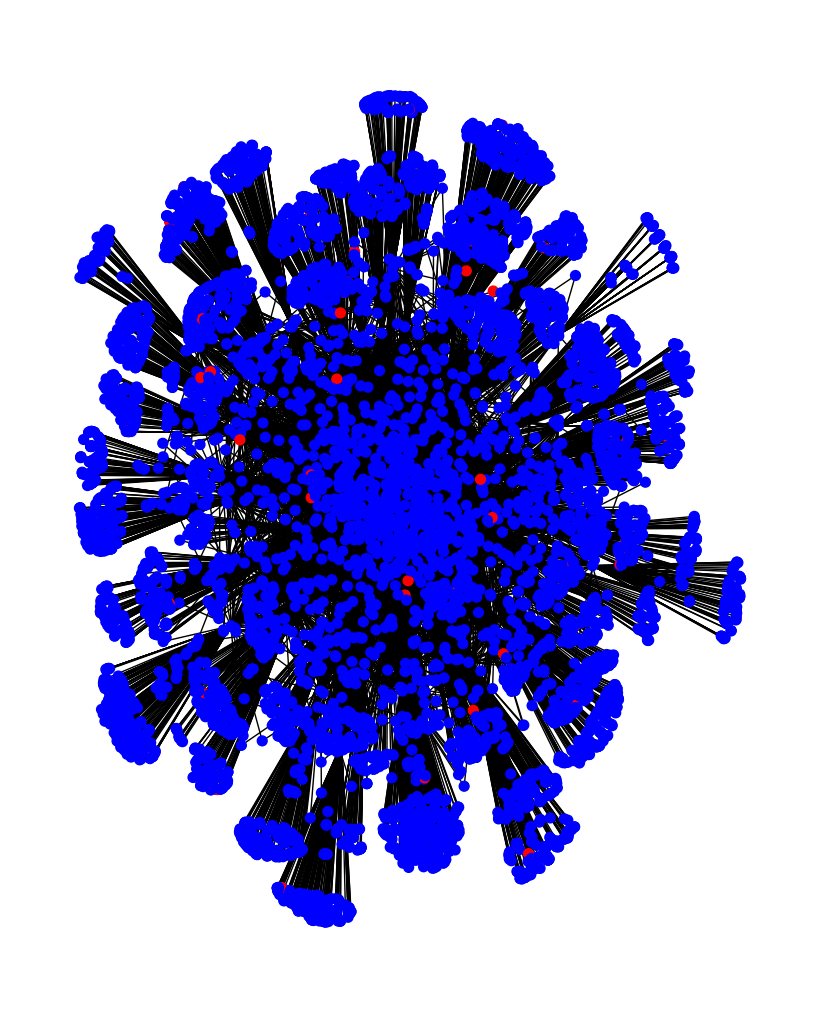

In [154]:
pos = net.spring_layout(G, seed=648)  # Seed layout for reproducible node positions
plt.figure(figsize=(8,10))
net.draw(G, pos,node_color=color_list, node_size=50)
plt.show()

#### **5. Create Functions for Island method**

Here we create the functions that we will use later to examine the islands in our projected graphs

In [156]:
def trim_edges(g, weight=1):
    g2 = net.Graph()
    for f,to, edata in g.edges(data=True):
        
        if edata['weight'] > weight:
            g2.add_edge(f,to,weight=edata['weight'])
    return g2

In [157]:
def island_method(g,iterations=5):
    weights = [edata['weight'] for f, to , edata in g.edges(data=True)]



    mn = int(min(weights))
    mx = int(max(weights))

    step = int((mx-mn)/iterations)

    return[[threshold,trim_edges(g,threshold)] for threshold in range(mn,mx,step)]
    

#### **6. Word tokens Projections**

We start by creating unweighted and weighted projections for the Users in the network. This projection represents the users that have the most movies in common with other users, since the edges in this projection would represent when two users have watched the same movie.

In [222]:
U1 = bipartite.projected_graph(G,word_tokens)
U2 = bipartite.weighted_projected_graph(G,word_tokens)

In [223]:
words_unweighted = pd.DataFrame([{'token':word,'degree':U1.degree(word)} for word in word_tokens]).sort_values(by='degree', ascending=False).reset_index(drop=True)
words_weighted = pd.DataFrame([{'token':word,'degree':U2.degree(word,weight='weight')} for word in word_tokens]).sort_values(by='degree', ascending=False).reset_index(drop=True)

##### **6.1 Top Word tokens based on number of connections**


In [226]:
top_10 = words_unweighted.iloc[:10,:].copy().sort_values(by='degree', ascending=False)
#top_10['user_cat'] = pd.Categorical(top_10.user, categories=pd.unique(top_10.user))

In [227]:
top_10

,token,degree
0,state,6569
1,would,6175
2,million,5233
3,fiscal,4955
4,cost,4880
5,could,4374
6,dollar,4294
7,fiscal impact,4174
8,impact,4174
9,revenue,4147


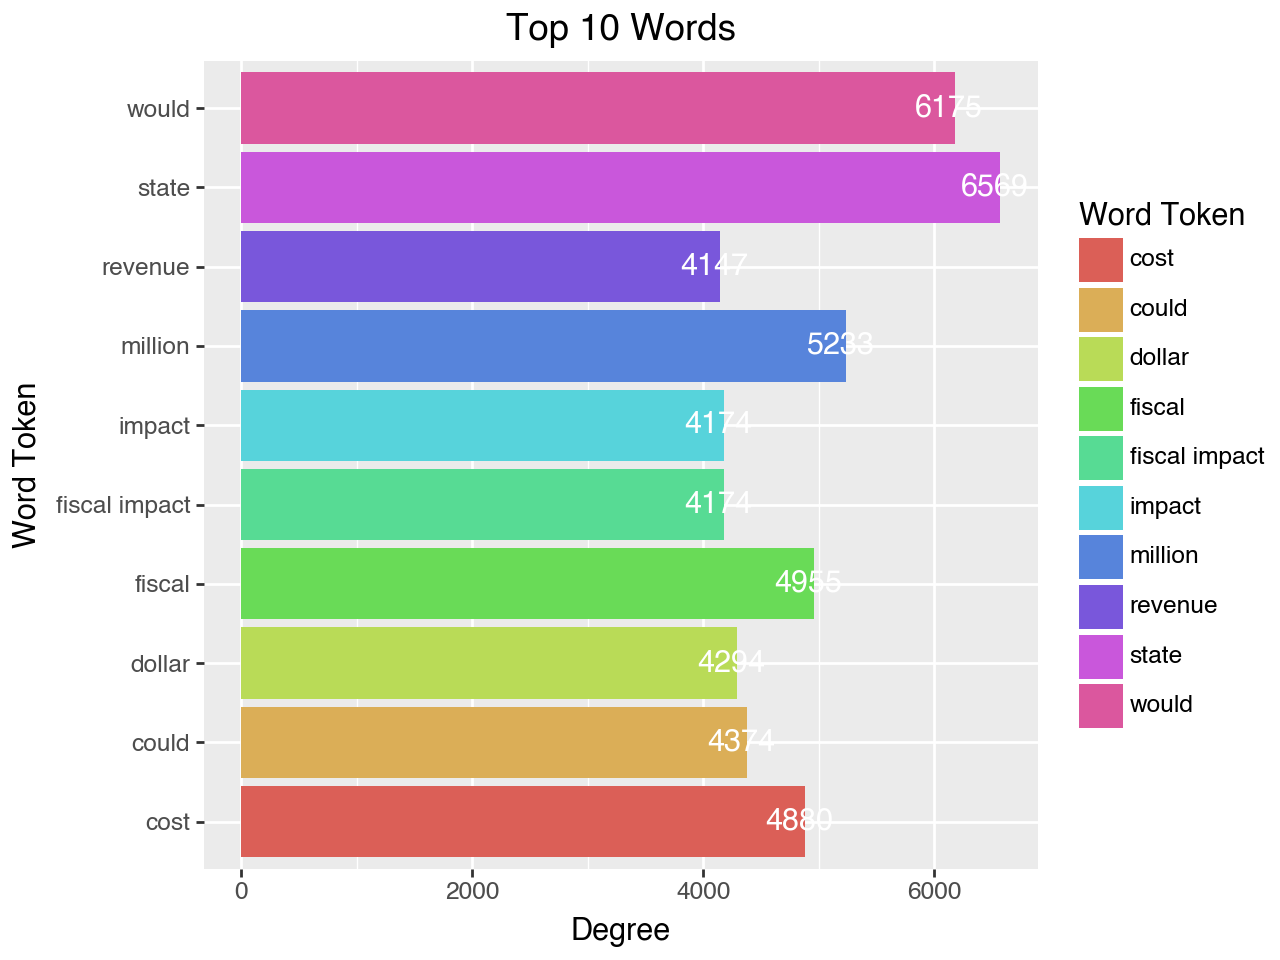

In [228]:
(
    ggplot(top_10)
    + aes(x='token', y='degree', fill='token')
    + geom_bar(stat='identity')
    + coord_flip()
    + labs(x='Word Token', y='Degree', fill='Word Token',title='Top 10 Words')
    + geom_text(aes(label='degree'),nudge_y=-50, color='white')
)

##### **6.2 Top Words based on weighted connections**


In [230]:
top_10 = words_weighted.iloc[:10,:].copy().sort_values(by='degree')
#top_10['user_cat'] = pd.Categorical(top_10.user, categories=pd.unique(top_10.user))

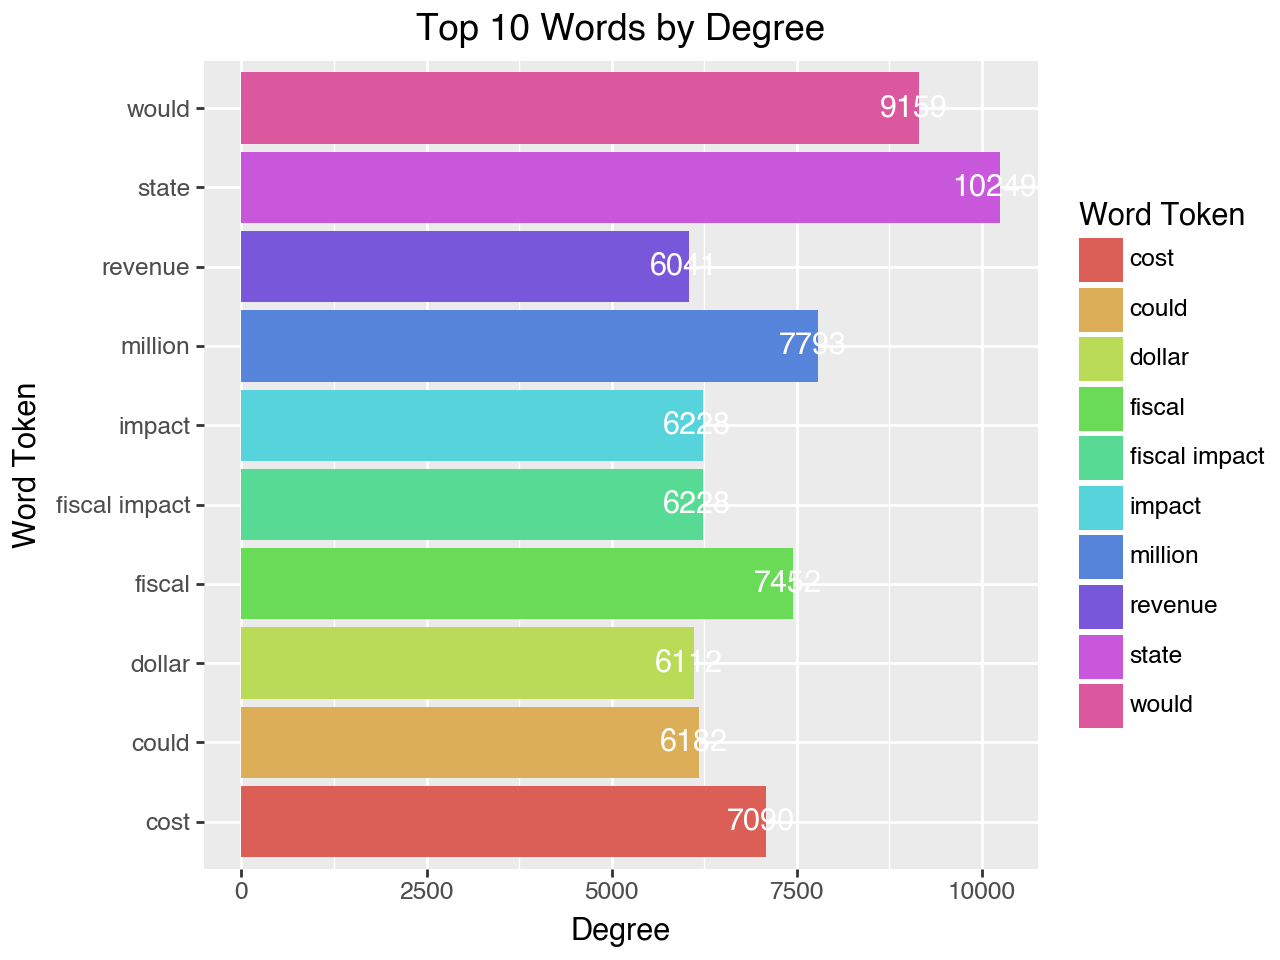

In [231]:
(
    ggplot(top_10)
    + aes(x='token', y='degree', fill='token')
    + geom_bar(stat='identity')
    + coord_flip()
    + labs(x='Word Token', y='Degree', fill='Word Token',title='Top 10 Words by Degree')
    + geom_text(aes(label='degree'),nudge_y=-70, color='white')
)

##### **6.3 Plot of unweighted word projection**

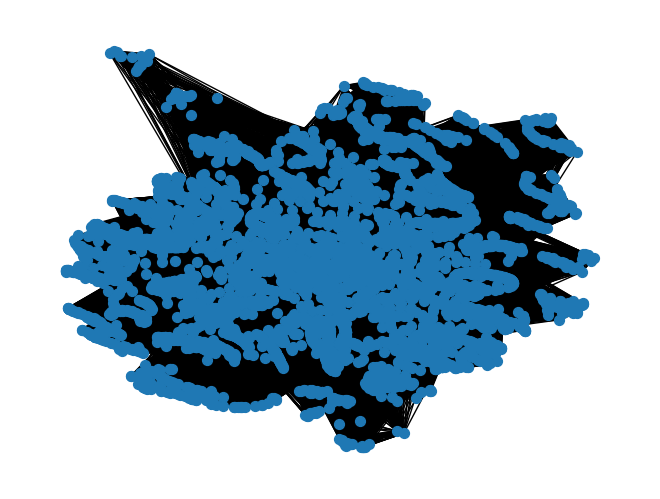

In [232]:
pos = net.spring_layout(U1, seed=648)  # Seed layout for reproducible node positions
net.draw(U1,pos,node_size=50)
plt.show()

##### 6.4 **Plot of weighted word projection**

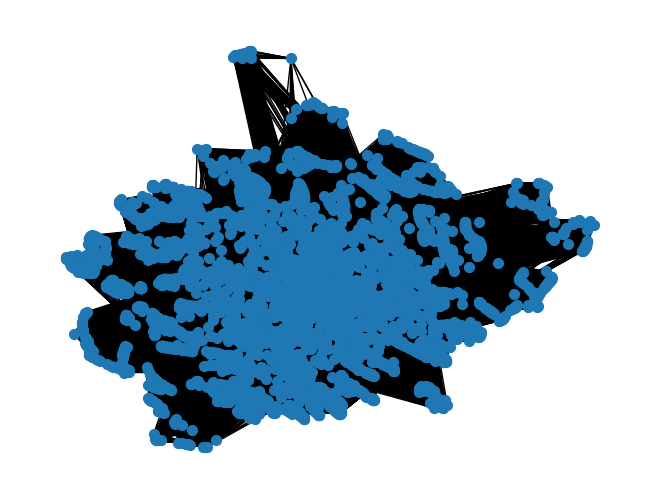

In [233]:
pos = net.spring_layout(U2, seed=648)  # Seed layout for reproducible node positions
net.draw(U2,pos,node_size=50)
plt.show()

##### **6.5 Island method**


We begin by running the island method on our Graph to identify specific sets of islandas in the network 

In [234]:
cc = U2.subgraph(next(net.connected_components(U2))).copy()

In [235]:
islands = island_method(cc)

In [237]:
for i in islands:
    #print(i[0],len(i[1]))
    print(i[0],len(i[1]),len(U2.subgraph(next(net.connected_components(i[1])))))

1 1249 1249
10 79 79
19 25 25
28 10 10
37 6 6


###### **6.5.1 - Island #1**

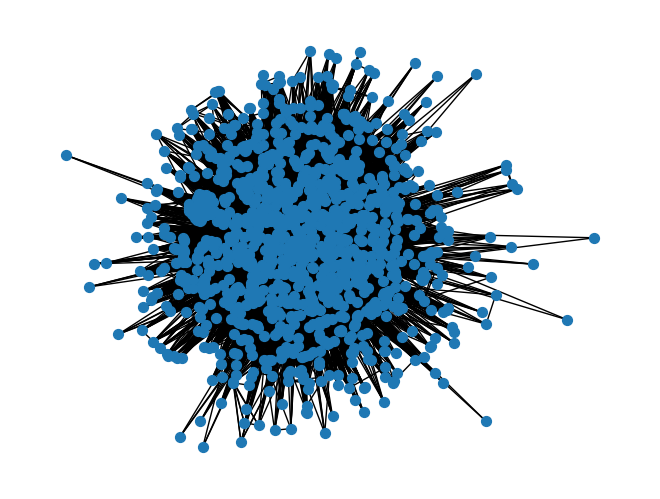

In [238]:
pos = net.spring_layout(islands[0][1], seed=648)  # Seed layout for reproducible node positions
net.draw(islands[0][1],pos,node_size=50)
plt.show()
#net.draw(islands[0][1])

###### **6.5.2 - Island #2**

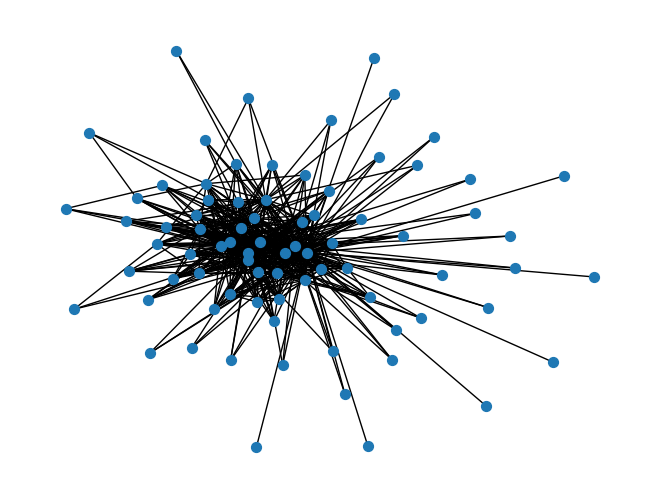

In [239]:
pos = net.spring_layout(islands[1][1], seed=648)  # Seed layout for reproducible node positions
net.draw(islands[1][1],pos,node_size=50)
plt.show()
#net.draw(islands[0][1])

###### **6.5.3 - Island #3**

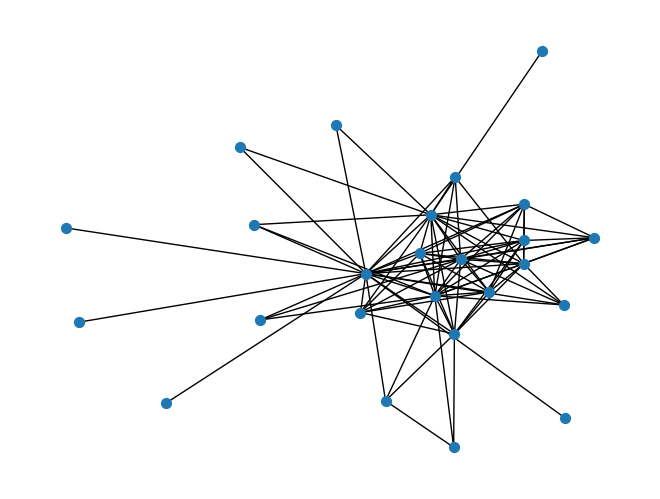

In [240]:
pos = net.spring_layout(islands[2][1], seed=648)  # Seed layout for reproducible node positions
net.draw(islands[2][1],pos,node_size=50)
plt.show()
#net.draw(islands[0][1])

###### **6.5.4 - Island #4**

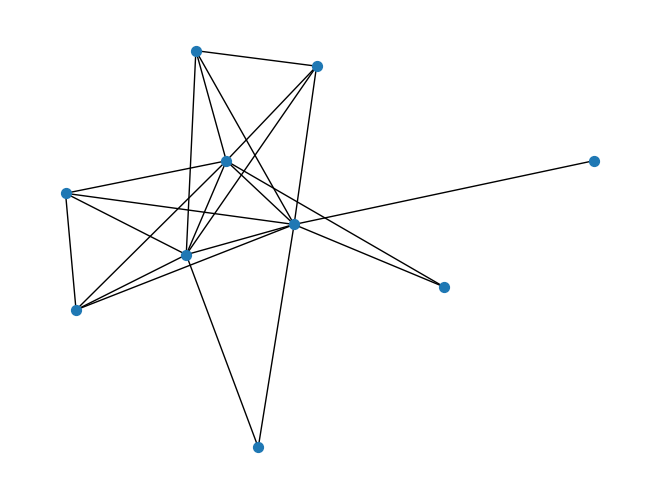

In [241]:
pos = net.spring_layout(islands[3][1], seed=648)  # Seed layout for reproducible node positions
net.draw(islands[3][1],pos,node_size=50)
plt.show()
#net.draw(islands[0][1])

###### **6.5.5 - Island #5**

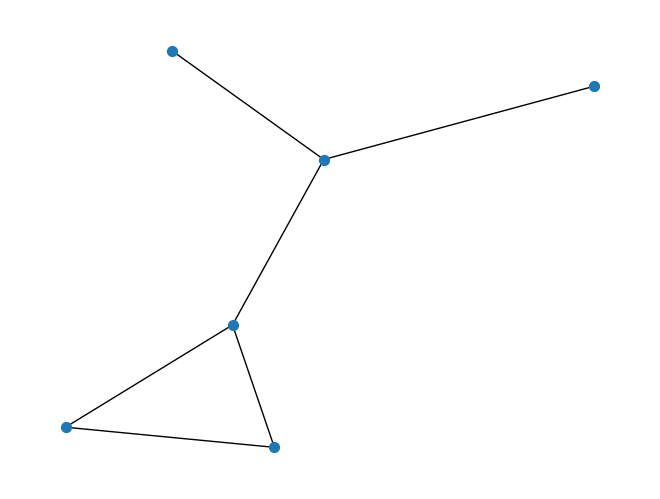

In [242]:
pos = net.spring_layout(islands[4][1], seed=648)  # Seed layout for reproducible node positions
net.draw(islands[4][1],pos,node_size=50)
plt.show()
#net.draw(islands[0][1])

#### **7. Proposition projection**

Next we are interested in looking at the projections of the bipartite network based on the movie titles.

In [244]:
P1 = bipartite.projected_graph(G,prop_names)
P2 = bipartite.weighted_projected_graph(G,prop_names)


In [245]:
props_unweighted = pd.DataFrame([{'prop':prop,'degree':P1.degree(prop)} for prop in prop_names]).sort_values(by='degree', ascending=False).reset_index(drop=True)
props_weighted = pd.DataFrame([{'prop':prop,'degree':P2.degree(prop,weight='weight')} for prop in prop_names]).sort_values(by='degree', ascending=False).reset_index(drop=True)

##### **7.1 Ranked movie titles (unweighted projection)**



###### **7.1.1 Top 10**
Here we see the Top 10 movie titles based on the number of users that watched that title. The list of top movies aren't really too suprising

In [ ]:
top_10 = titles_unweighted.iloc[:10,:].copy().sort_values(by='degree')

In [ ]:
top_10.iloc[:,:2].sort_values(by='degree', ascending=False)

,title,degree
0,Forrest Gump (1994),152
1,"Shawshank Redemption, The (1994)",151
2,Pulp Fiction (1994),150
3,"Silence of the Lambs, The (1991)",148
4,Braveheart (1995),148
5,Toy Story (1995),148
6,Schindler's List (1993),146
7,Terminator 2: Judgment Day (1991),142
8,"Usual Suspects, The (1995)",137
9,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),135



###### **7.1.2 Bottom 10**
Here we see the bottom 10 movie titles based on the number of users that watched that title.

In [ ]:
bottom_10 = titles_unweighted.iloc[-10:,:].copy().sort_values(by='degree', ascending=False)

In [ ]:
bottom_10.iloc[:,:2].sort_values(by='degree', ascending=False)

,title,degree
144,"Dark Knight Rises, The (2012)",60
145,"Good, the Bad and the Ugly, The (Buono, il bru...",60
146,Phenomenon (1996),59
147,Life Is Beautiful (La Vita è bella) (1997),58
148,"Time to Kill, A (1996)",57
149,City of God (Cidade de Deus) (2002),55
150,Almost Famous (2000),55
151,Avatar (2009),51
152,Harry Potter and the Half-Blood Prince (2009),49
153,Executive Decision (1996),47


I'm somewhat suprised to see the Harry Potter movie and Dark Knight Rises included in the list of the bottom 10 movies.

##### **7.2 Top 10 movie title (weighted projection)**

Here we see the Top 10 movie titles based on the number of connections and the rating that they received.

###### **7.2.1 Top 10**

In [ ]:
top_10 = titles_weighted.iloc[:10,:].copy().sort_values(by='degree')

In [ ]:
top_10.sort_values(by='degree', ascending=False)

,title,degree
0,"Shawshank Redemption, The (1994)",1640
1,Pulp Fiction (1994),1446
2,Forrest Gump (1994),1437
3,Braveheart (1995),1314
4,"Silence of the Lambs, The (1991)",1238
5,Apollo 13 (1995),1107
6,Batman (1989),1052
7,Dances with Wolves (1990),1041
8,Schindler's List (1993),990
9,Ace Ventura: Pet Detective (1994),988


When we consider the ratings that the movies received, we see a list of movies that one would consider to be a list of critically acclaimed movies.

###### **7.2.2 Bottom 10**

In [ ]:
bottom_10 = titles_weighted.iloc[-10:,:].copy().sort_values(by='degree')

In [ ]:
bottom_10.sort_values(by='degree', ascending=False)

,title,degree
144,Kill Bill: Vol. 1 (2003),129
145,City of God (Cidade de Deus) (2002),120
146,Butch Cassidy and the Sundance Kid (1969),120
147,"Good, the Bad and the Ugly, The (Buono, il bru...",116
148,Harry Potter and the Half-Blood Prince (2009),116
149,Armageddon (1998),115
150,Mystery Science Theater 3000: The Movie (1996),115
151,Avatar (2009),112
152,Life Is Beautiful (La Vita è bella) (1997),111
153,Almost Famous (2000),74


##### **7.3 Plot of movie connections (unweighted)**

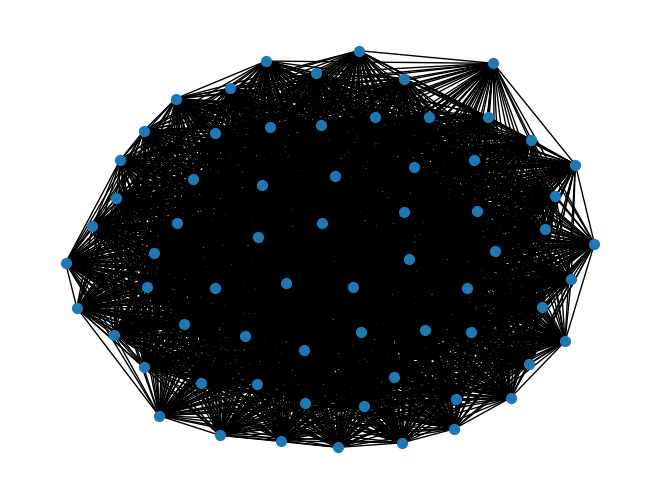

In [249]:
pos = net.spring_layout(P1, seed=648)  # Seed layout for reproducible node positions
net.draw(P1,pos,node_size=50)
plt.show()

##### **7.4 Plot of movie connections (weighted projection)**

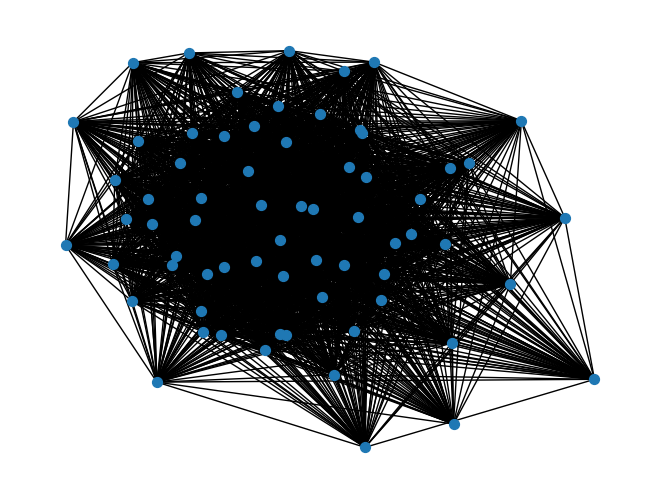

In [251]:
pos = net.spring_layout(P2, seed=648)  # Seed layout for reproducible node positions
net.draw(P2,pos,node_size=50)
plt.show()

##### **7.5 Island method**


We begin by running the island method on our Graph to identify specific sets of islandas in the network 

In [252]:
cc = P2.subgraph(next(net.connected_components(P2))).copy()

In [253]:
islands = island_method(cc)

In [254]:
for i in islands:
    #print(i[0],len(i[1]))
    print(i[0],len(i[1]),len(P2.subgraph(next(net.connected_components(i[1])))))

1 67 67
20 55 52
39 27 7
58 9 3
77 3 3
96 3 3


###### **7.5.1 - Island #1**

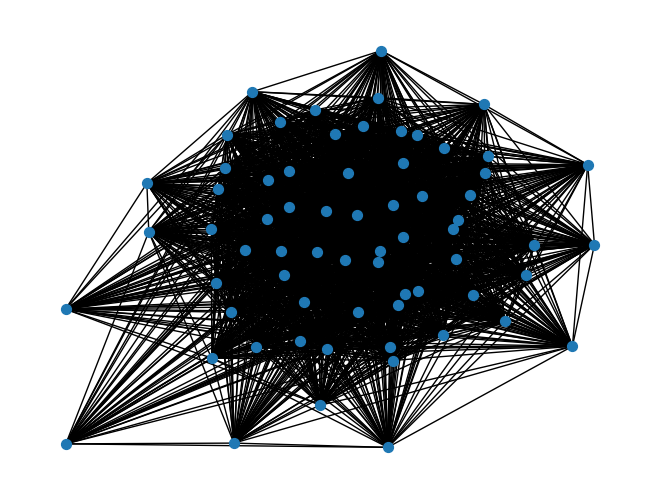

In [255]:
pos = net.spring_layout(islands[0][1], seed=648)  # Seed layout for reproducible node positions
net.draw(islands[0][1],pos,node_size=50)
plt.show()
#net.draw(islands[0][1])

###### **7.5.2 - Island #2**

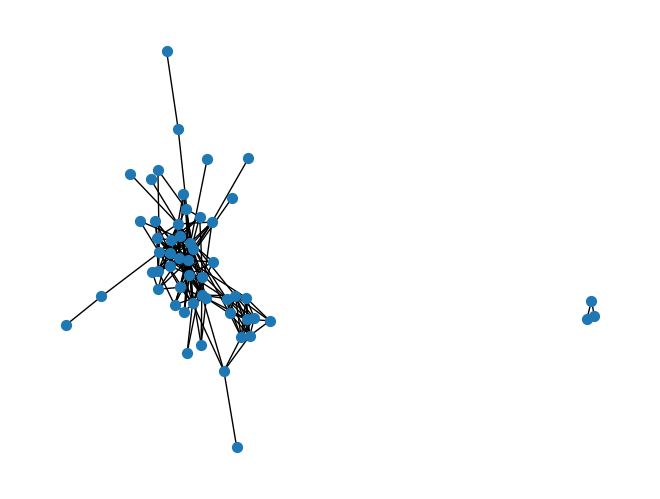

In [256]:
pos = net.spring_layout(islands[1][1], seed=648)  # Seed layout for reproducible node positions
net.draw(islands[1][1],pos,node_size=50)
plt.show()
#net.draw(islands[1][1])

###### **7.5.3 - Island #3**

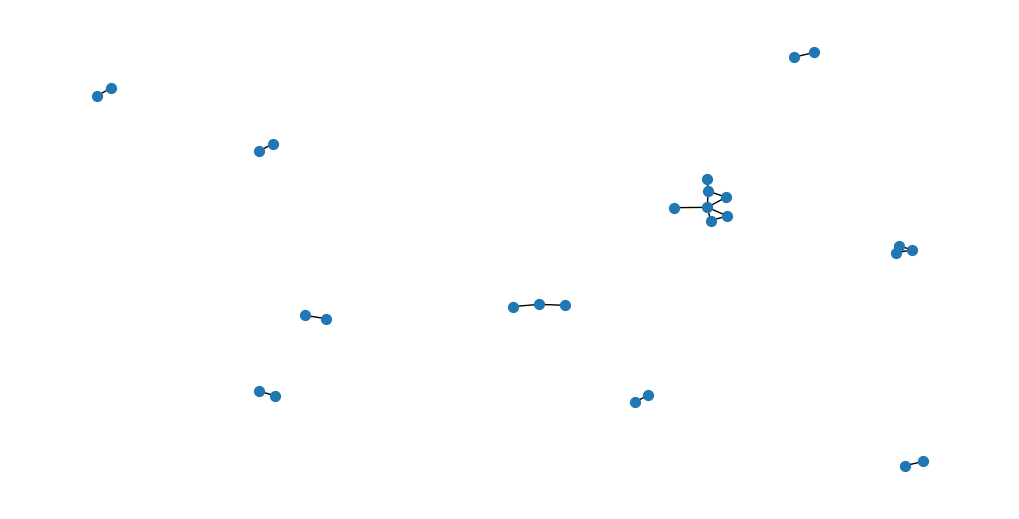

In [257]:
plt.figure(figsize=(10,5))
pos = net.spring_layout(islands[2][1], seed=648)  # Seed layout for reproducible node positions
net.draw(islands[2][1],pos,node_size=50)
plt.show()
#net.draw(islands[2][1])

###### **7.5.4 - Island #4**

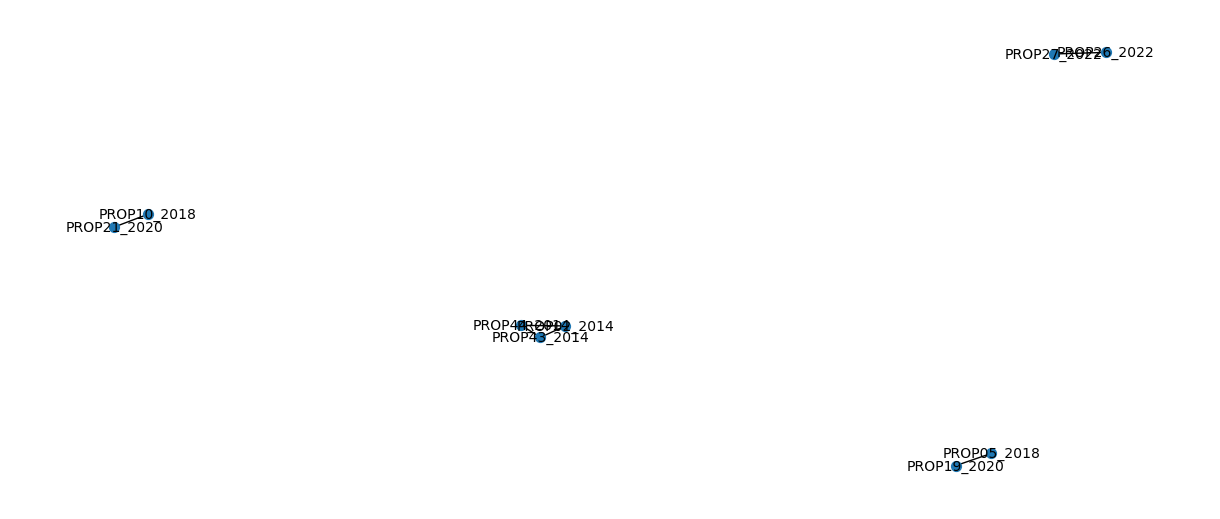

In [258]:
plt.figure(figsize=(12,5))
pos = net.spring_layout(islands[3][1], seed=648)  # Seed layout for reproducible node positions
net.draw(islands[3][1],pos,node_size=50,with_labels=True,font_size=10)
plt.show()
#net.draw(islands[3][1])

###### **7.5.5 - Island #5**

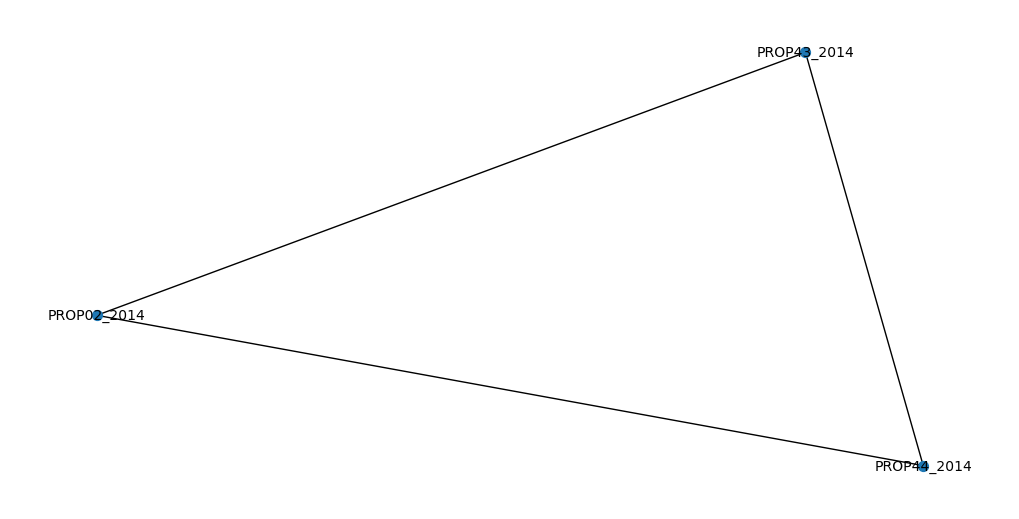

In [259]:
plt.figure(figsize=(10,5))
pos = net.spring_layout(islands[4][1], seed=648)  # Seed layout for reproducible node positions
net.draw(islands[4][1],pos,node_size=50,with_labels=True,font_size=10)
plt.show()
#net.draw(islands[4][1])

#### **8. Conclusion**



In this network, we find similar results as when we analyzed the network based on the eigenvector and degree centrality measures. The top movies in the network are titles that we would expect based on our own familiarity with movies. Looking at the Island network with weight of 34 (meaning there are at least 34 connections), we find that the network consists only of **Forrest Gump, Pulp Fiction, Shawshank Redemption and Braveheart**. Three of these four films together create a closed triad, with Shawshank Redemption serving as a connector to the movie Braveheart. From a personal perspective this fits into my own movie watching reality. I've seen Forrest Gump, Pulp Fiction and Shawshank Redemption; but I have not seen Bravehart. 